# Linear Models
### Common pitfalls in the interpretation of coefficients of linear models

_Source_: 

https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py

https://scikit-learn.org/stable/modules/linear_model.html

_Dataset_: 

https://www.openml.org/d/534 

In [1]:
from sklearn import datasets, linear_model

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.linear_model import (
    Ridge,
    RidgeCV
)

from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor
)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedKFold
)

from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    median_absolute_error
)

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml

**Load the diabetes dataset**

In [2]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2] # Use only one feature

**Split the data into training/testing sets**

In [3]:
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

**Split the targets into training/testing sets**

In [4]:
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

In [5]:
regr = linear_model.LinearRegression()
regr.fit(diabetes_X_train, diabetes_y_train)
diabetes_y_pred = regr.predict(diabetes_X_test)

In [6]:
print("Coefficients:", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

Coefficients: [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


**Plot outputs**

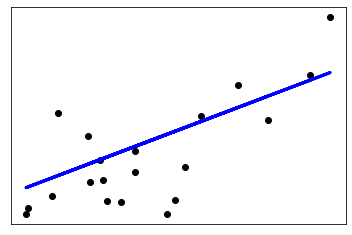

In [7]:
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### The dataset: wages

**Load dataset as a panda dataframe**

In [8]:
survey = fetch_openml(data_id=534, as_frame=True)

**Get dataset features**

In [9]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [10]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


**Get dataset target for prediction**

In [11]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

**Split the sample into a train and a test dataset**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Get some insights**

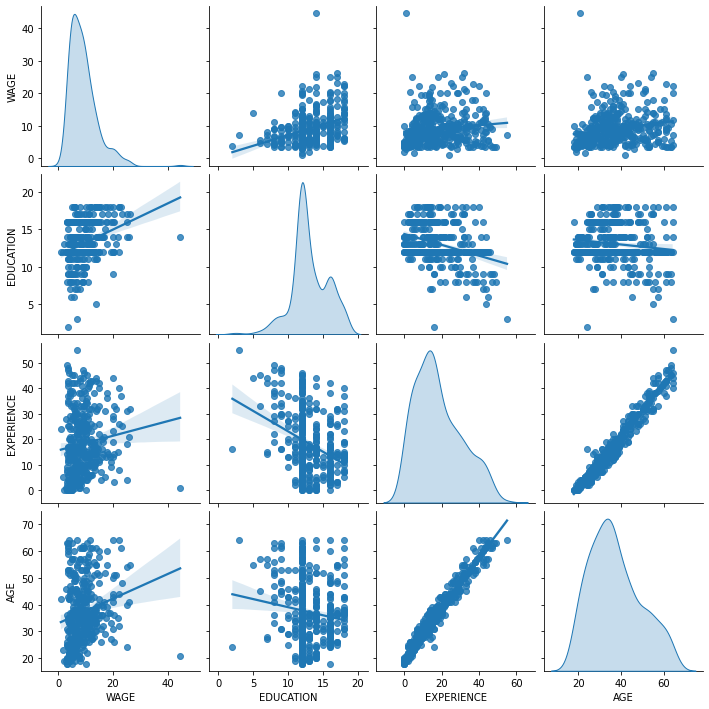

In [13]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)

sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

### The machine-learning pipeline

In [14]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.2 KB


In [15]:
categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [16]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), 
        func=np.log10, 
        inverse_func=sp.special.exp10
    )
)

### Processing the dataset

In [17]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

(0.0, 27.0)

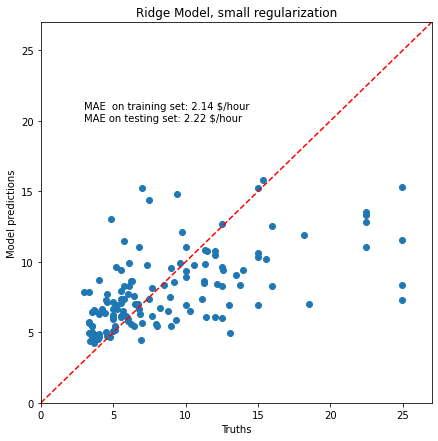

In [18]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE  on training set: {mae:.2f} $/hour"

y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(7, 7))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge Model, small regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")

plt.xlim([0, 27])
plt.ylim([0, 27])

### Interpreting coefficients: scale matters

In [19]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names
)

coefs

,Coefficients
RACE_Hispanic,-0.013548
RACE_Other,-0.009104
RACE_White,0.022566
OCCUPATION_Clerical,0.000054
OCCUPATION_Management,0.090537
OCCUPATION_Other,-0.025093
OCCUPATION_Professional,0.071972
OCCUPATION_Sales,-0.046627
OCCUPATION_Service,-0.091044
SECTOR_Construction,-0.000141


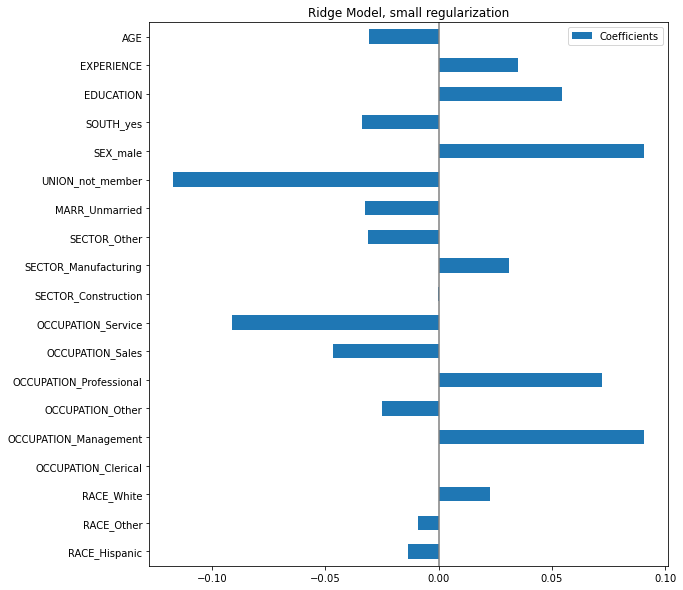

In [20]:
coefs.plot(kind="barh", figsize=(12,10))
plt.title("Ridge Model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

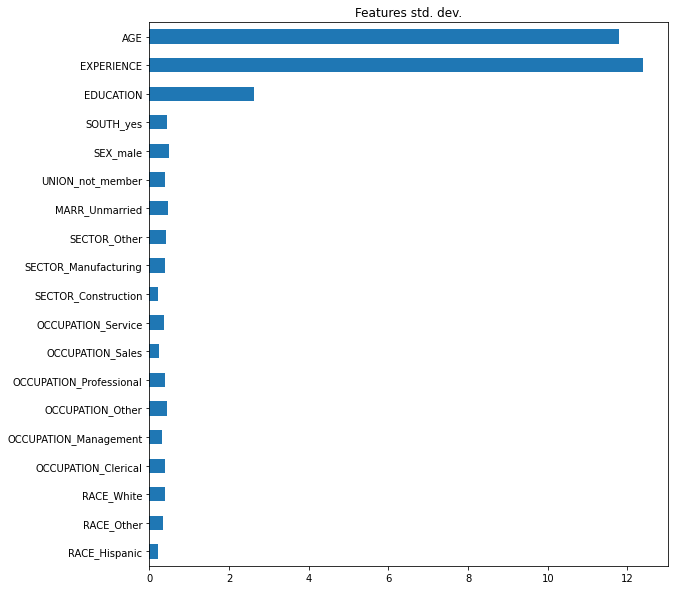

In [21]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps["columntransformer"].transform(X_train), 
    columns=feature_names
)

X_train_preprocessed.std(axis=0).plot(kind="barh", figsize=(12,10))
plt.title("Features std. dev.")
plt.subplots_adjust(left=0.3)

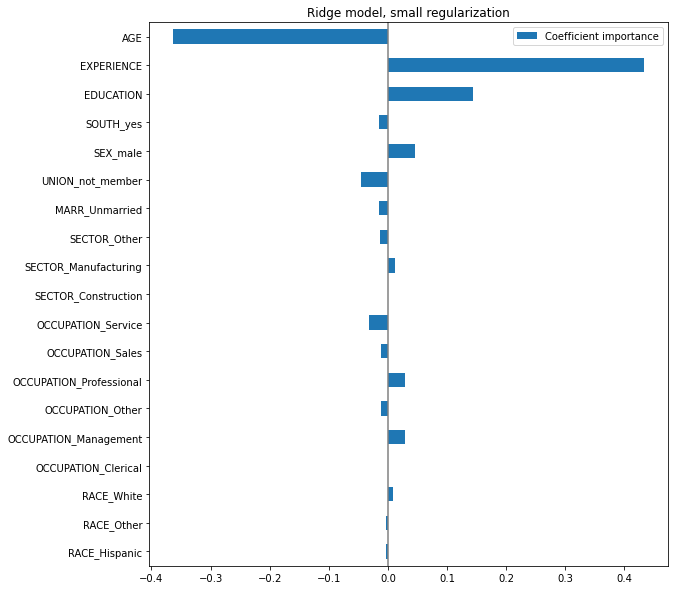

In [22]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)

coefs.plot(kind="barh", figsize=(12, 10))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

### Checking the variability of the coefficients

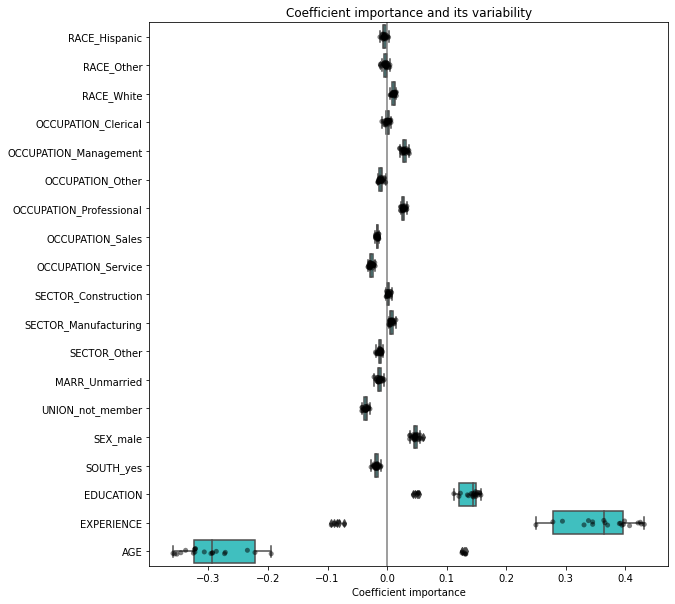

In [23]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5)
cv_model = cross_validate(model, X, y, cv=repeated_kfold, return_estimator=True, n_jobs=2)

coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_ * X_train_preprocessed.std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)

plt.figure(figsize=(12, 10))

sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)

plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

### The problem of correlated variables

Text(0.5, 1.0, 'Co-variations of coefficients for AGE and EXPIRIENCE across  folds')

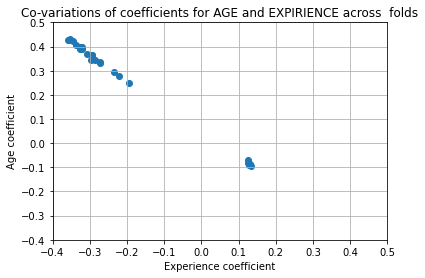

In [24]:
# Two regions are populated: when the EXPERIENCE coefficient is positive the AGE one is negative and vice-versa.

plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])

plt.title("Co-variations of coefficients for AGE and EXPIRIENCE across  folds")

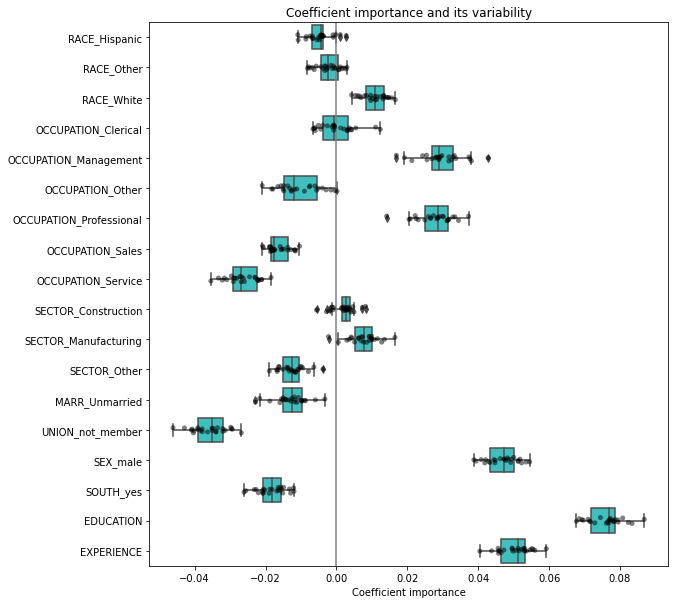

In [25]:
# To go further we remove one of the 2 features and check what is the impact on the model stability.
column_to_drop = ["AGE"]

repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5)
cv_model = cross_validate(model, X.drop(columns=column_to_drop), y, cv=repeated_kfold, return_estimator=True, n_jobs=2)


coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names[:-1],
)
plt.figure(figsize=(12, 10))

sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)

plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

### Preprocessing numerical variables

In [26]:
preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="passthrough"
)

In [27]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10)
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e

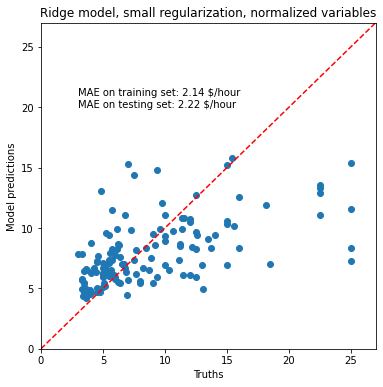

In [28]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"

y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, small regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

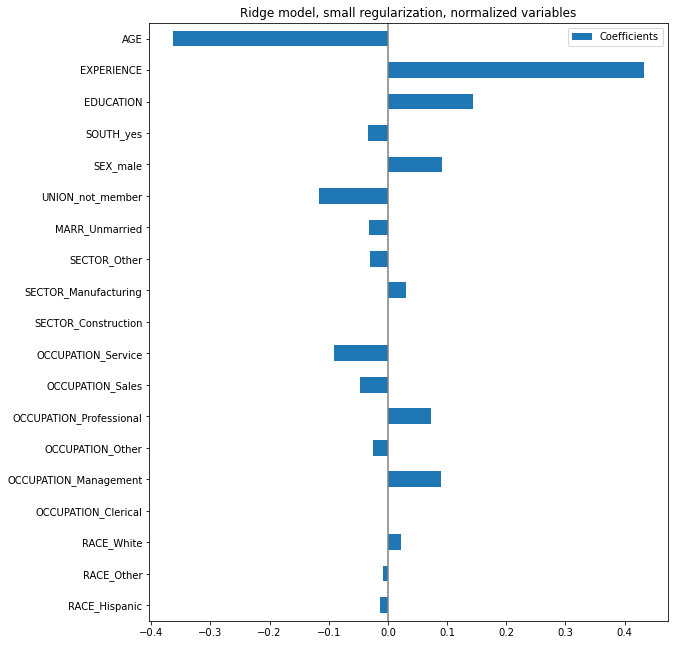

In [29]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot(kind="barh", figsize=(12, 11))
plt.title("Ridge model, small regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

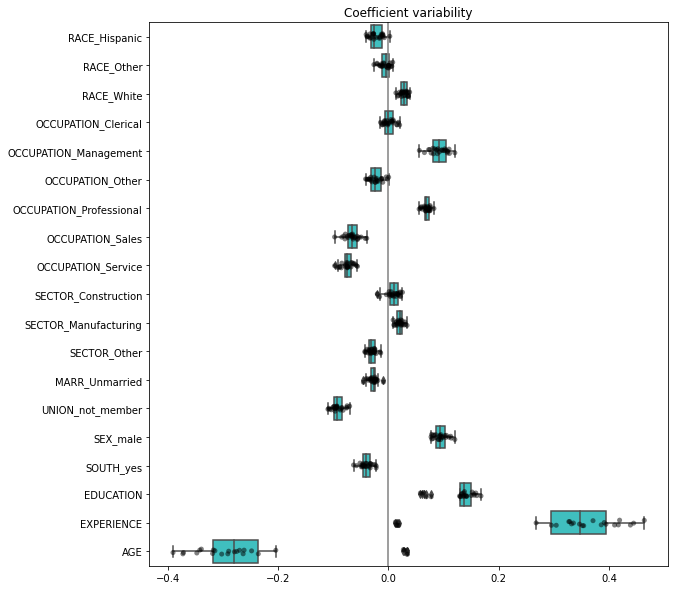

In [30]:
cv_model = cross_validate(model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5), return_estimator=True, n_jobs=2)

coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)

plt.figure(figsize=(12, 10))

sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)

plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

### Linear models with regularization

In [31]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas

In [32]:
model[-1].regressor_.alpha_

10.0

(0.0, 27.0)

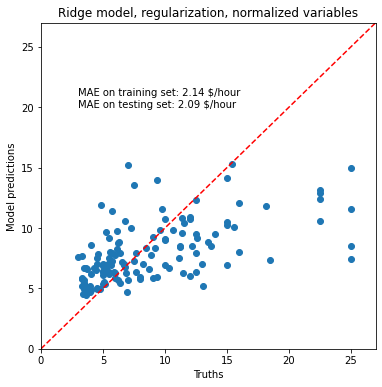

In [33]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"

y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Ridge model, regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
plt.ylim([0, 27])

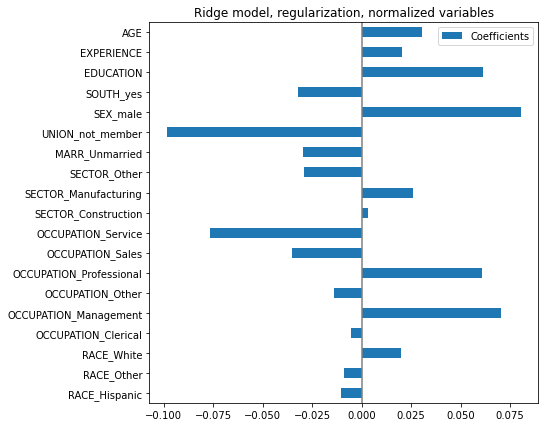

In [35]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

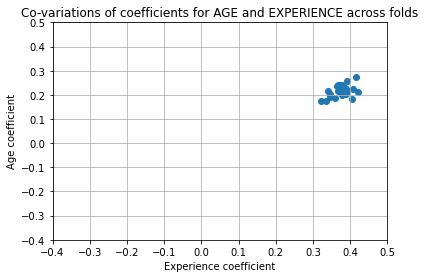

In [37]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)

plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

### Linear models with sparse coefficients

In [39]:
from sklearn.linear_model import LassoCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

In [41]:
model[-1].regressor_.alpha_

0.001

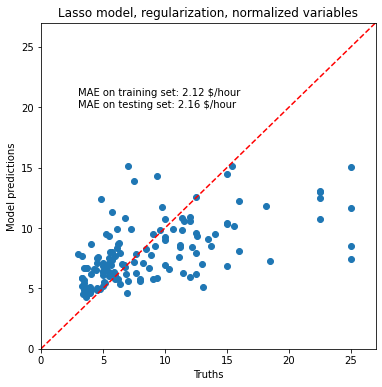

In [43]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title("Lasso model, regularization, normalized variables")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

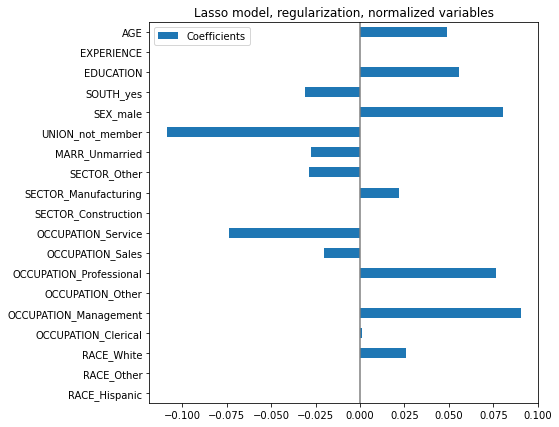

In [44]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)